In [1]:
using StateSpaceDynamics
using LinearAlgebra
using Random
using Plots

In [2]:
#create a state-space model for the tutorial
obs_dim = 10
latent_dim = 2

# set up the state parameters
A = 0.95 * [cos(0.25) -sin(0.25); sin(0.25) cos(0.25)] 
Q = Matrix(0.1 * I(2))

x0 = [0.0; 0.0]
P0 = Matrix(0.1 * I(2))

# set up the observation parameters
C = randn(obs_dim, latent_dim)
R = Matrix(0.5 * I(10))


# create the state-space model
true_ssm = GaussianLDS(;A=A, 
                        Q=Q, 
                        C=C, 
                        R=R, 
                        x0=x0, 
                        P0=P0, 
                        obs_dim=obs_dim, 
                        latent_dim=latent_dim, 
                        fit_bool=fill(true, 6))

# simulate data from the model
tSteps = 500
latents, Y = StateSpaceDynamics.sample(true_ssm, tSteps, 1) # one trial for tutorial purposes
     

([0.020228838056851706 0.16753742901377147 … -0.7813556432746397 -1.3046517136612061; -0.4861200671077373 -0.2629998311861538 … 0.4192022075337014 0.25754736617775825;;;], [-1.00220955250857 0.5331920591956136 … -0.7869792355456257 -1.1606375748723177; 1.4371565921560254 -0.835770107630089 … 0.2621445356138732 0.4288606036302451; … ; -1.210757212469733 -0.703508036832315 … 1.387159395785022 0.8520172569696477; 0.9298551618374169 1.5211798522316713 … -0.5905314931872713 -1.3927223899394017;;;])

In [3]:
x_smooth, p_smooth, _ = StateSpaceDynamics.smooth(true_ssm, Y)

([0.09826883907396991 0.25901599748690873 … -0.5406235214626464 -1.0470607381814339; -0.4151020958563613 -0.335552794495019 … 0.5674258724021086 0.2685940262519597;;;], [0.04423697357924131 -0.0015887184820733377; -0.0015887184820733377 0.024685465129473318;;; 0.05193683482527669 -0.0016302168812413892; -0.0016302168812413892 0.026053659415702486;;; 0.05321338692386644 -0.0015365357829541823; -0.0015365357829541823 0.02614030787436654;;; … ;;; 0.05401028221523228 -0.001617476144735145; -0.001617476144735145 0.026193439758170095;;; 0.05696349514637076 -0.0018867140747099052; -0.0018867140747099052 0.026499474969186514;;; 0.07395520249496805 -0.0012304357831106711; -0.0012304357831106711 0.03158518760881443;;;;], [0.0 0.0; 0.0 0.0;;; 0.018035938141862315 -0.003568556473343079; 0.0015527645147656345 0.005632301514035271;;; 0.021147388938064886 -0.003747560727440234; 0.0018773199511673544 0.0059464927127309735;;; … ;;; 0.02196059571580071 -0.0037686396463312566; 0.001929334762646344 0.0059

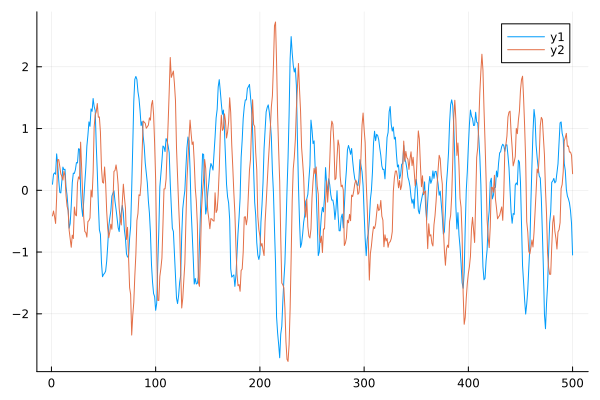

In [4]:
plot(x_smooth[:,:,1]')

In [5]:
using NeuralOperators, Lux, Random, Optimisers, Zygote, CairoMakie

In [11]:
latent_dim = 2             # desired latent state dimension
width = 32                 # FNO channel width
depth = 4                  # number of Fourier layers
modes = 8                  # number of Fourier modes
tin = size(Y, 1)           # observation dimension
T = size(Y,2)

500

In [12]:
# ---------------------------------------------------
# 2) Build encoder & decoder
# ---------------------------------------------------
width = 32; depth = 4; modes = 8
chs_enc = (tin, fill(width, depth)..., latent_dim)
chs_dec = (latent_dim, fill(width, depth)..., tin)
encoder = FourierNeuralOperator(elu; chs=chs_enc, modes=(modes,), permuted=Val(true))
decoder = FourierNeuralOperator(elu; chs=chs_dec, modes=(modes,), permuted=Val(true))

FourierNeuralOperator(
    model = Chain(
        layer_1 = Conv((1,), 2 => 32),  # 96 parameters
        layer_2 = Chain(
            layer_1 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
            layer_2 = OperatorKernel(
                layer = Parallel(
                    connection = Fix1(add_act, elu),
                    layer_1 = Conv((1,), 32 => 32),  # 1_056 parameters
                    layer_2 = OperatorConv(32 => 32, (8,), FourierTransform{ComplexF32}; permuted = static(true)),  # 8_192 parameters
                ),
            ),
        ),
        layer_3 = Chain(
            layer_1 = Conv((1,), 32 => 32, elu),  # 1_056 parameters
            layer_2 = Conv((1,), 32 => 1

In [41]:
# ---------------------------------------------------
# 3) Setup parameters, state, optimizers
# ---------------------------------------------------
rng = Random.default_rng()
params_dec, state_dec = Lux.setup(rng, decoder)
opt_dec = Optimisers.Adam(1e-3)
opt_state_dec = Optimisers.setup(opt_dec, params_dec)

ps_enc, st_enc = Lux.setup(rng, encoder)
opt_enc = Optimisers.Adam(1e-3)
opt_state_enc = Optimisers.setup(opt_enc, ps_enc)

(layer_1 = (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999)))), layer_2 = (layer_1 = (layer_1 = (weight = Leaf(Adam(eta=0.001, beta=(0.9, 0.999), epsilon=1.0e-8), (Float32[0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0

In [42]:
y = reshape(Y, T, tin, 1)
y = Float32.(y)

500×10×1 Array{Float32, 3}:
[:, :, 1] =
 -1.00221    -2.32254   -0.389654  …  -0.76497     1.45623   -0.869644
  1.43716    -0.394407   2.82542      -1.40398     1.32212   -2.08596
 -0.961389    1.22426    1.2846        1.43151    -1.14687   -0.899326
  0.0391868  -0.769921  -1.33406       0.0281272   1.01996    0.815024
 -0.407129    1.90638    2.26942      -1.00112     1.10759   -0.130856
  1.44822     0.148486   2.32941   …  -0.57854     1.02344   -2.47562
 -0.665806    0.681319   1.35056      -0.615609   -0.614081   0.199059
 -0.549608    1.50034    1.53828       0.671081   -1.39694    2.15712
 -1.21076     2.04571   -2.49952       0.695643   -1.82063    4.89415
  0.929855   -0.607787  -0.352752     -0.57331     3.54153   -2.02412
  ⋮                                ⋱                         
 -0.117737    0.403639   1.28571       1.02712    -3.059      0.428861
  1.01761     0.14417    0.107523     -0.83206    -0.194804   0.906907
 -0.997098   -1.45157    1.28167       1.02417     

In [43]:
# forward pass via Lux.apply: returns latent sequence and updated state
latent_seq, st = Lux.apply(encoder, y, params_enc, state_enc)

# latent_seq has shape (spatial, out_ch, batch) i.e. (T, latent_dim, 1)
println("Encoded latent sequence size: ", size(latent_seq))

Encoded latent sequence size: (500, 2, 1)


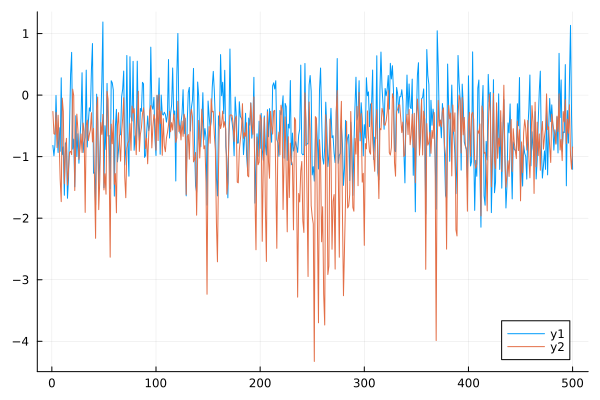

In [44]:
plot(latent_seq[:,:,1])

In [45]:
recon_seq, st_dec = Lux.apply(decoder, latent_seq, params_dec, state_dec)

(Float32[0.24149145 -0.39998296 … 0.17670704 -0.18755904; 0.20224577 -0.518188 … 0.05783418 -0.13018604; … ; 0.19499557 -0.22302066 … -0.40390056 -0.15864249; 0.17272735 -0.5987441 … 0.008597001 -0.08085735;;;], (layer_1 = NamedTuple(), layer_2 = (layer_1 = (layer_1 = NamedTuple(), layer_2 = NamedTuple()), layer_2 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())), layer_3 = (layer_1 = NamedTuple(), layer_2 = NamedTuple())))

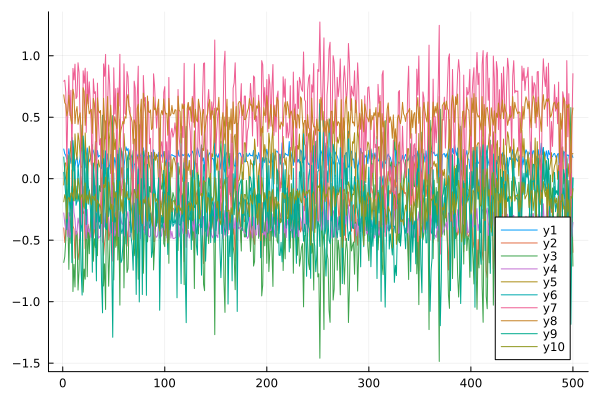

In [46]:
plot(recon_seq[:,:,1])

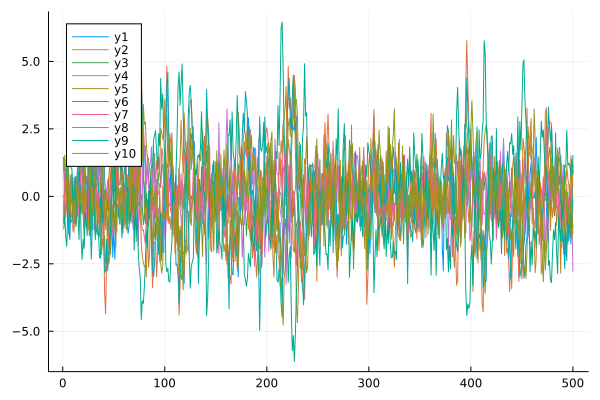

In [47]:
plot(Y[:,:,1]')

In [48]:
using Statistics                          # for `mean` function

In [49]:
latent_true = reshape(x_smooth, T, latent_dim, 1)  # true latent states
latent_true = Float32.(latent_true)

500×2×1 Array{Float32, 3}:
[:, :, 1] =
  0.0982688   0.756616
 -0.415102    0.152993
  0.259016    0.800508
 -0.335553    0.354274
  0.282323    0.374393
 -0.425985    0.268305
  0.259761   -0.0155232
 -0.536872    0.376885
  0.589639   -0.504285
 -0.115399    0.0661783
  ⋮          
 -0.588604    0.717291
  0.172278   -0.203394
 -0.741208    0.617854
  0.405741   -0.327905
 -0.772466    0.61956
  1.13579    -0.540624
 -0.626183    0.567426
  0.97997    -1.04706
 -0.120803    0.268594

In [57]:
# ---------------------------------------------------
# 3) Setup parameters, state, optimizer
# ---------------------------------------------------
rng = Random.default_rng()
ps_enc, st_enc = Lux.setup(rng, encoder)
opt_enc = Optimisers.Adam(1e-3)
opt_state_enc = Optimisers.setup(opt_enc, ps_enc)

# ---------------------------------------------------
# 4) Training loop (v4: flatten grads for compatibility)
# ---------------------------------------------------
epochs = 200
for epoch in 1:epochs
    function loss_fn(ps)
        pred_latent, _ = Lux.apply(encoder, y, ps, st_enc)
        return mean((pred_latent .- latent_true).^2)
    end

    loss, back = Zygote.pullback(ps_enc) do ps
        loss_fn(ps)
    end
    grads_named = back(1f0)

    # Flatten gradients to match ps_enc structure
    flat_grads = Functors.functor(ps_enc)[2](grads_named)

    ps_enc, opt_state_enc = Optimisers.update(opt_enc, ps_enc, flat_grads, opt_state_enc)

    if epoch % 10 == 0
        @info "Epoch=$epoch Loss=$loss"
    end
end

@info "Encoder training complete."

ErrorException: type Tuple has no field layer_1

In [56]:
using Functors